In [2]:
import pandas as pd
import numpy as np
import nltk
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import os


In [3]:
from pathlib import Path

# Get the current notebook directory (ml/scripts/)
notebook_dir = Path.cwd()

# Go up one level to ml/, then down to data/
data_dir = notebook_dir.parent / "data"
normalized_data_path = data_dir / "normalized" / "forecasts.json"

In [4]:
df = pd.read_json(normalized_data_path)
df.shape

(2929, 9)

In [6]:
df.isnull().sum()

id                 0
date               0
datetime           0
summary            0
summary_norm       0
summary_no_stop    0
levels_text        0
levels_1to5        0
levels_0to4        0
dtype: int64

In [5]:
lvl = df["levels_0to4"].apply(pd.Series)  # cols: below_treeline, treeline, above_treeline
long = lvl.melt(value_vars=["below_treeline","treeline","above_treeline"],
                var_name="band", value_name="level")  # level is 0..5
# per-band counts
long.value_counts(["band","level"]).sort_index()

# overall counts (all bands combined)
long["level"].value_counts().sort_index()

level
0      18
1    2896
2    3476
3    2065
4     332
Name: count, dtype: int64

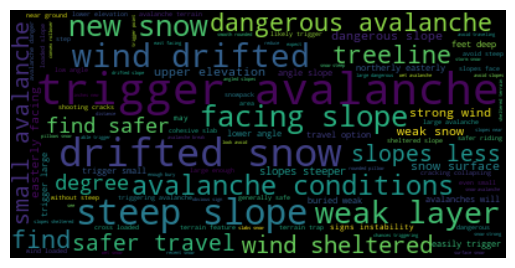

In [7]:
%matplotlib inline
wordcloud_text = ' '.join(df["summary_no_stop"])
wordcloud_two = WordCloud().generate(wordcloud_text)

plt.imshow(wordcloud_two, interpolation='bilinear')
plt.axis("off")


plt.show()

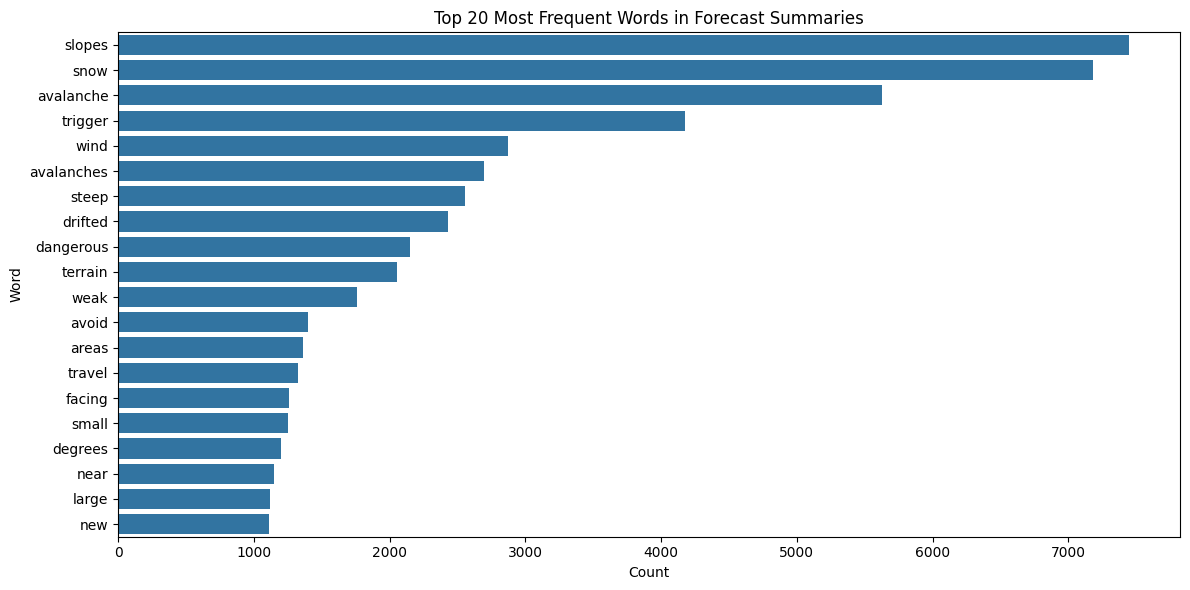

In [9]:
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns

vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(df["summary_no_stop"])
word_counts = X.toarray().sum(axis=0)

# Create DataFrame of top words
words = vectorizer.get_feature_names_out()
word_freq = pd.DataFrame({'word': words, 'count': word_counts})
top_words = word_freq.sort_values(by='count', ascending=False).head(20)

# Plot
plt.figure(figsize=(12,6))
sns.barplot(data=top_words, x='count', y='word')
plt.title("Top 20 Most Frequent Words in Forecast Summaries")
plt.xlabel("Count")
plt.ylabel("Word")
plt.tight_layout()
plt.show()

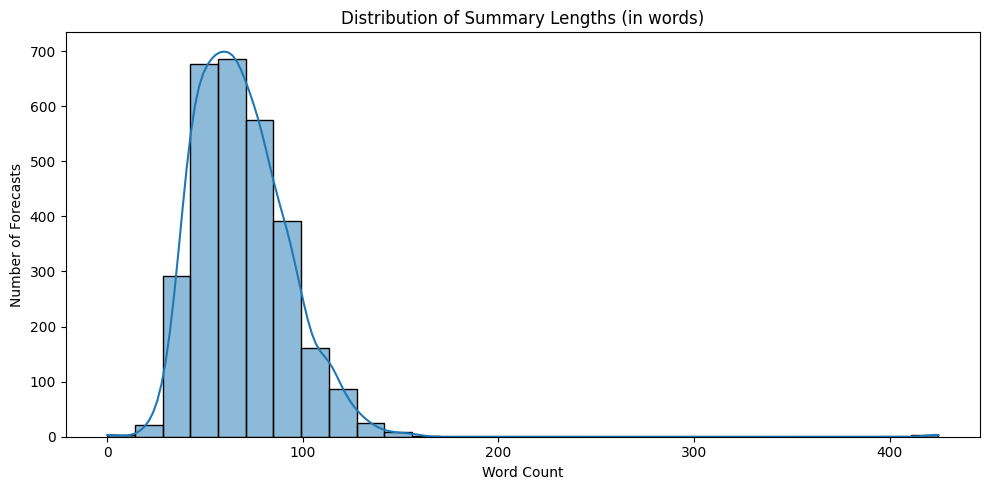

In [10]:
length = df["summary_no_stop"].str.split().apply(len)
char = df["summary_no_stop"].str.len()

plt.figure(figsize=(10, 5))
sns.histplot(length, bins=30, kde=True)
plt.title("Distribution of Summary Lengths (in words)")
plt.xlabel("Word Count")
plt.ylabel("Number of Forecasts")
plt.tight_layout()
plt.show()

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    stop_words='english',
    max_features=5000,   
    ngram_range=(1, 2)   
)
X_tfidf = tfidf.fit_transform(df["summary_no_stop"])

mean_tfidf = X_tfidf.mean(axis=0).A1 
vocab = tfidf.get_feature_names_out()

tfidf_df = pd.DataFrame({
    "term": vocab,
    "mean_tfidf": mean_tfidf
}).sort_values(by="mean_tfidf", ascending=False)

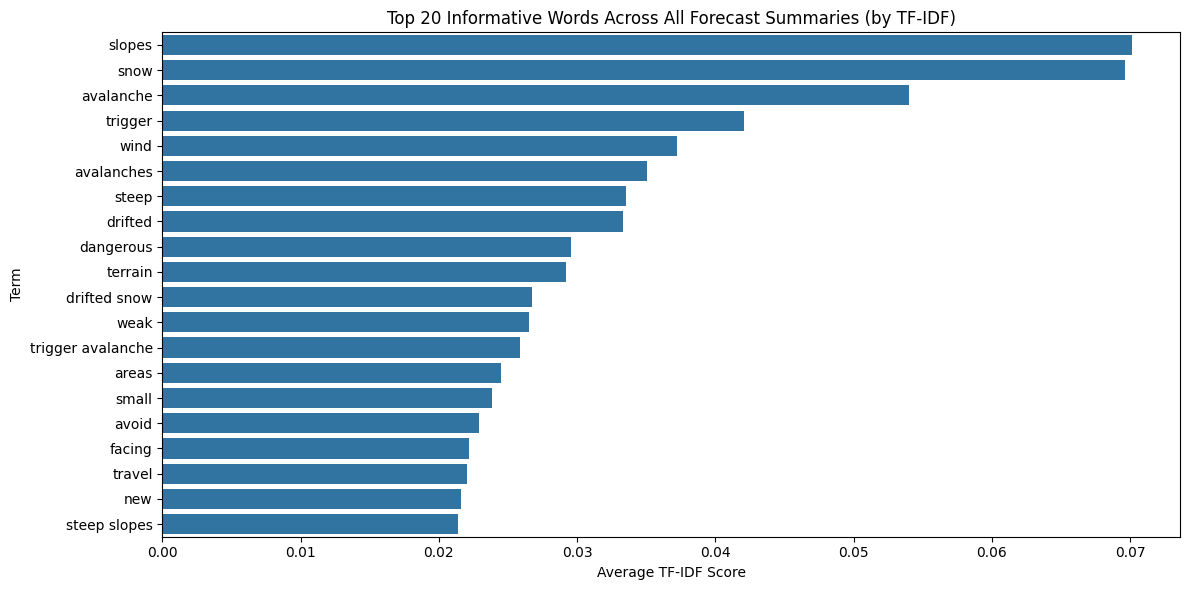

In [12]:
top_terms = tfidf_df.head(20)
plt.figure(figsize=(12, 6))
sns.barplot(data=top_terms, y="term", x="mean_tfidf")
plt.title("Top 20 Informative Words Across All Forecast Summaries (by TF-IDF)")
plt.xlabel("Average TF-IDF Score")
plt.ylabel("Term")
plt.tight_layout()
plt.show()